In [41]:
import os
import sys
import h5py
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib.ticker import PercentFormatter
from scipy import signal
from scipy.stats import norm, pearsonr

%matplotlib inline

In [3]:
# database full path
database_name = 'whistlers.h5'
database_location = os.path.join(os.getcwd().split(os.environ.get('USER'))[0],os.environ.get('USER'), 'wdml', 'Data')
database_path = os.path.join(database_location,database_name)

# data variables
awd_events = 2
sites = ['marion', 'sanae']

In [4]:
def scale_to_extreme(arr, thr):
    arr = np.asarray(arr)
    arr_min = arr.min()
    arr_max = arr.max()
    _arr = [arr_min if a < thr else arr_max for a in arr]
    return _arr

In [5]:
def extract_spectrogram_info(spectrogram_data):
    '''Extract the time, frequency axis values as well as the 
            spectrogram data.
    inputs:
        spectrogram_data: the spectrogram data including the 
        time and frequency information.
    outputs: 
        time: time values
        frequency: frequency values
        spectrogram: spectrogram
    '''
    time = spectrogram_data[0,1:]
    frequency = spectrogram_data[1:,0]
    spectrogram = spectrogram_data[1:,1:]
    return time, frequency, spectrogram

File: /home/othniel/wdml/Data/awdEvents1/marion_data/2013-05-11UT16:14:51.15709664.marion.vr2
Mean of PSD:  1.2079
Standard deviation of PSD:  0.8818
Max PSD:  4.6338
Min PSD: -6.0528
Correlation:  0.9957


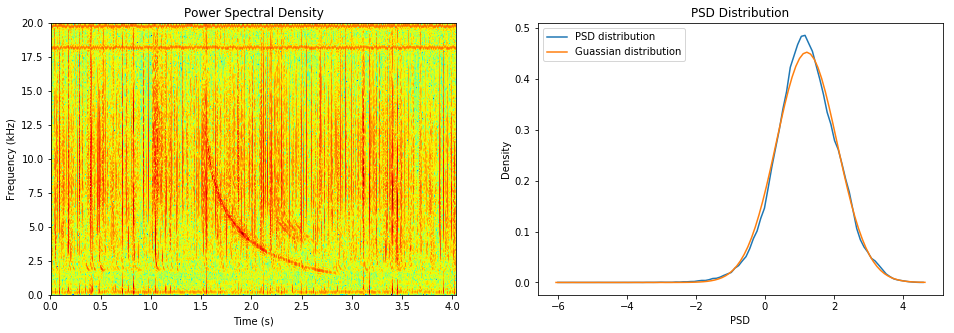

In [61]:
f  = h5py.File(database_path, 'r')
grp_wh = f[os.path.join('awdEvents'+str(1), sites[0],'whistler traces')]
files = list(grp_wh.keys())
file = files[np.random.randint(len(files))] # select a random sample
# create np array to store sample information
whdf = np.empty(grp_wh[file].shape)
grp_wh[file].read_direct(whdf)
fs = grp_wh[file].attrs['sample frequency']
f.close()
# get spectrogram
f, t, Sxx = signal.spectrogram(whdf[:,0], fs=fs, detrend='linear', nfft=512 , noverlap=64, scaling='density',mode='psd')
Sxx_psd = np.log10(Sxx)
# get mean
mean = np.mean(Sxx_psd)
std = np.std(Sxx_psd)
# Compute histogram
(n, bins) = np.histogram(Sxx_psd.flatten(), bins=100, density=True)  # NumPy version (no plot)
# Compute pdf
pdf = norm.pdf(bins, mean, std)
# correlation between gaussian and pdf
corr = pearsonr(n,pdf[:-1])

print('File:', os.path.join(os.getcwd().split(os.environ.get('USER'))[0],
                            os.environ.get('USER'), 'wdml', 'Data','awdEvents'+str(1), sites[0]+'_data', file))
print('Mean of PSD: ', round(mean,4))
print('Standard deviation of PSD: ', round(std,4))
print('Max PSD: ', round(Sxx_psd.max(),4))
print('Min PSD:', round(Sxx_psd.min(),4))
print('Correlation: ', round(corr[0],4))

# plot 
plt.figure(figsize=(16,5))
fig = plt.subplot(1,2,1)
img = plt.pcolormesh(t,f/1000,Sxx_psd, cmap='jet')
# fig.colorbar(mappable=img, label='Power [dB]')
plt.title('Power Spectral Density')
plt.xlabel('Time (s)')
plt.ylabel('Frequency (kHz)')

plt.subplot(1,2,2)
plt.plot(.5*(bins[1:]+bins[:-1]), n)
plt.plot(bins, pdf)
plt.title('PSD Distribution')
plt.xlabel('PSD')
plt.ylabel('Density')
plt.legend(['PSD distribution', 'Guassian distribution'])
plt.show()
